In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import itertools
import warnings
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

df = pd.read_excel('C:/Users/Yuwanut/Desktop/Master@KU/อ.เทพฤทธิ์/Data/no_tourist_foreign.xlsx') #อ่านไฟล์

In [2]:
df_groupby = df.groupby(['date', 'region_eng'])['value'].sum()
df_groupby.to_csv('no_tourist_f.csv')

In [3]:
df1 = pd.read_csv('no_tourist_f.csv')
df2 = df1.groupby("date")["value"].sum().reset_index()

all_value = df2['value']

Optimal ARIMA order: (0, 4, 3)
AIC:  814.5187129769216
BIC:  819.5510991290075
RMSE Test Score: 26,916,587.08
MAE Test Score: 21,003,764.59


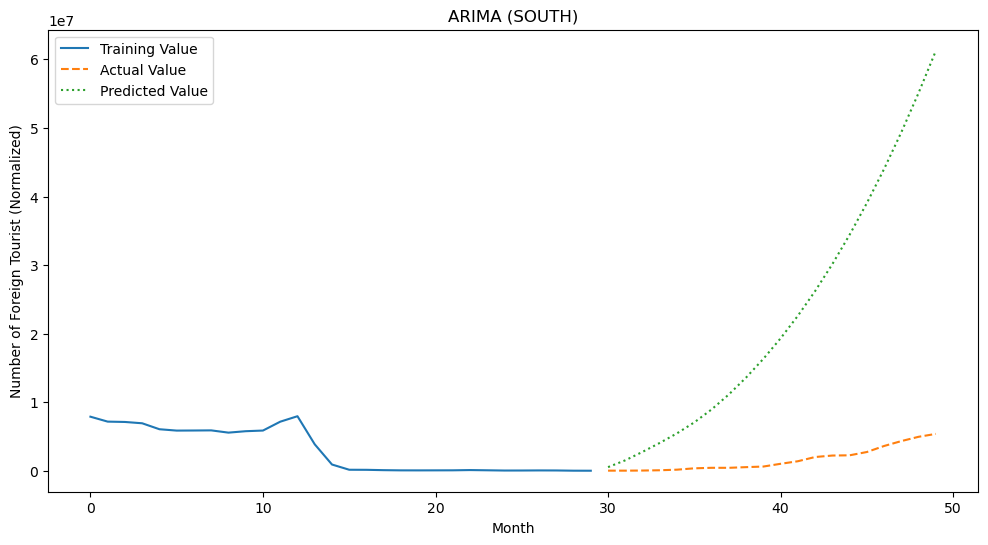

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
RMSE Train Score: 936,838.79
RMSE Test Score: 532,400.44
MAE Train Score: 501,398.81
MAE Test Score: 430,742.30


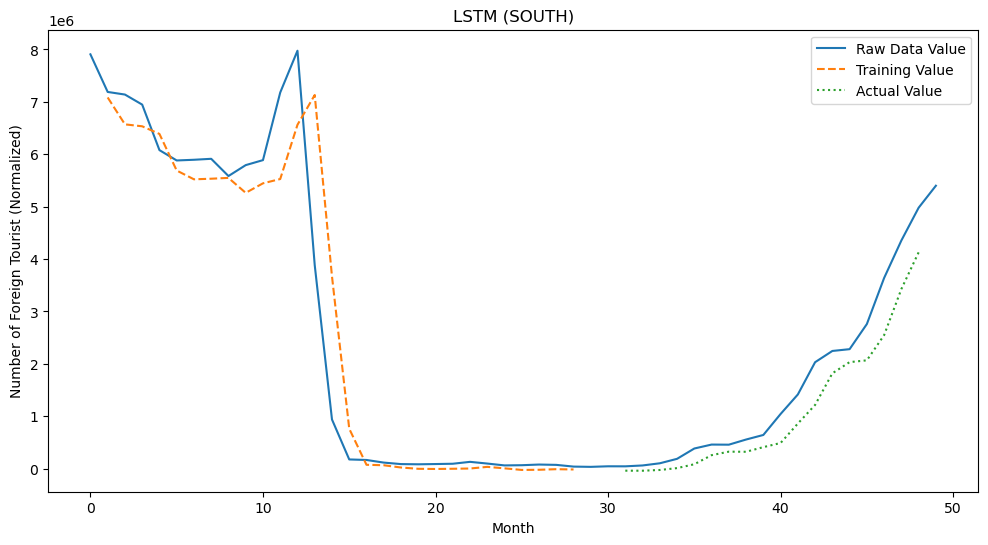

In [4]:
#ARIMA - ALL REGION

# Ignore warnings
warnings.filterwarnings("ignore")

#divide data into training and testing sets
train_data = all_value[:int(len(all_value) * 0.6)]
test_data = all_value[int(len(all_value) * 0.6):]

#determine optimal arima parameters with grid search
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
pdq_combinations = list(itertools.product(p_values, d_values, q_values))
best_aic = float('inf')
best_order = None
best_model = None

# Iterate through possible parameter combinations
for order in pdq_combinations:
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except Exception as e:
        print(f"Error fitting ARIMA model with order {order}")
print(f"Optimal ARIMA order: {best_order}")
print("AIC: ", best_aic)
print("BIC: ", best_model.bic)

#forecast net foreign with arima model
predictions = model_fit.forecast(steps = len(test_data))

#compute root mean squared error (rmse)
rmse = sqrt(mean_squared_error(test_data, predictions))
print('RMSE Test Score: {:,.2f}'.format(rmse))
mae = mean_absolute_error(test_data, predictions)
print('MAE Test Score: {:,.2f}'.format(mae))

#display actual vs predicted net foreign value
plt.figure(figsize = (12, 6))
plt.plot(train_data, label = 'Training Value')
plt.plot(test_data, label = 'Actual Value', linestyle='--')
plt.plot(test_data.index, predictions, label = 'Predicted Value', linestyle=':')
plt.xlabel('Month')
plt.ylabel('Number of Foreign Tourist (Normalized)')
plt.title('ARIMA (SOUTH)')
plt.legend()
plt.show()

#-------------------------------------------------------------

#LSTM - CENTRAL

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
tf.random.set_seed(12)

# load the dataset
dataframe = df2['value']
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

# split into train and test sets
train_size = int(len(dataset) * 0.6)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('RMSE Train Score: {:,.2f}'.format(trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('RMSE Test Score: {:,.2f}'.format(testScore))

train_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
print('MAE Train Score: {:,.2f}'.format(train_mae))
test_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('MAE Test Score: {:,.2f}'.format(test_mae))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize = (12, 6))
plt.plot(scaler.inverse_transform(dataset), label = 'Raw Data Value')
plt.plot(trainPredictPlot, label = 'Training Value', linestyle='--')
plt.plot(testPredictPlot, label = 'Actual Value', linestyle=':')
plt.xlabel('Month')
plt.ylabel('Number of Foreign Tourist (Normalized)')
plt.title('LSTM (SOUTH)')
plt.legend()
plt.show()

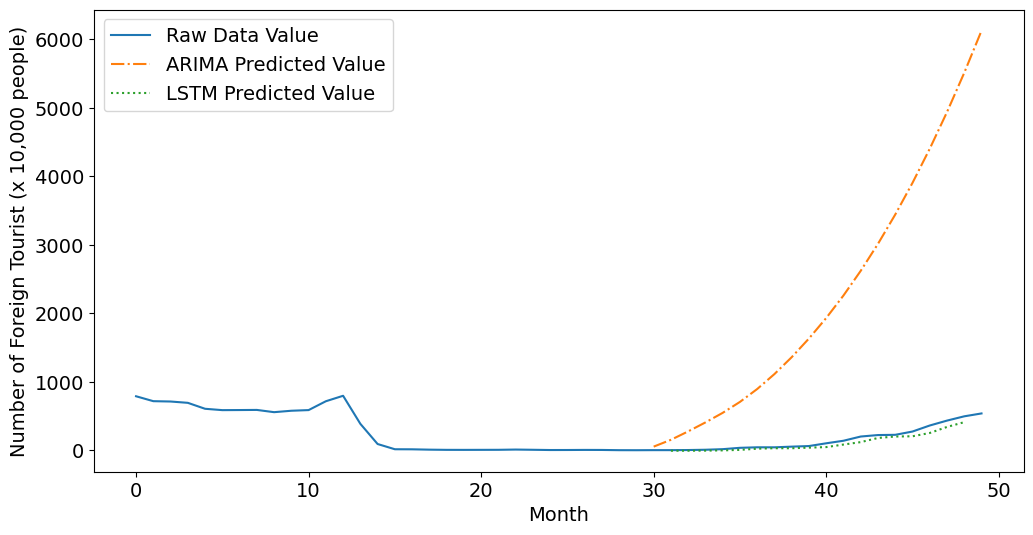

In [5]:
#display actual vs predicted net foreign value
plt.figure(figsize = (12, 6))

plt.plot(scaler.inverse_transform(dataset), label = 'Raw Data Value')
plt.plot(test_data.index, predictions, label = 'ARIMA Predicted Value', linestyle='-.')
plt.plot(testPredictPlot, label = 'LSTM Predicted Value', linestyle=':')

plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Foreign Tourist (x 10,000 people)', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

y_ticks = plt.gca().get_yticks()  # รับค่า ticks ในแกน y
plt.gca().set_yticklabels([f'{int(tick / 10000)}' for tick in y_ticks])

ax = plt.gca()  # get current axis
ax.spines['top'].set_visible(True)    # แสดงขอบบน
ax.spines['right'].set_visible(True)  # แสดงขอบขวา
ax.spines['left'].set_visible(True)   # แสดงขอบซ้าย
ax.spines['bottom'].set_visible(True) # แสดงขอบล่าง

plt.show()

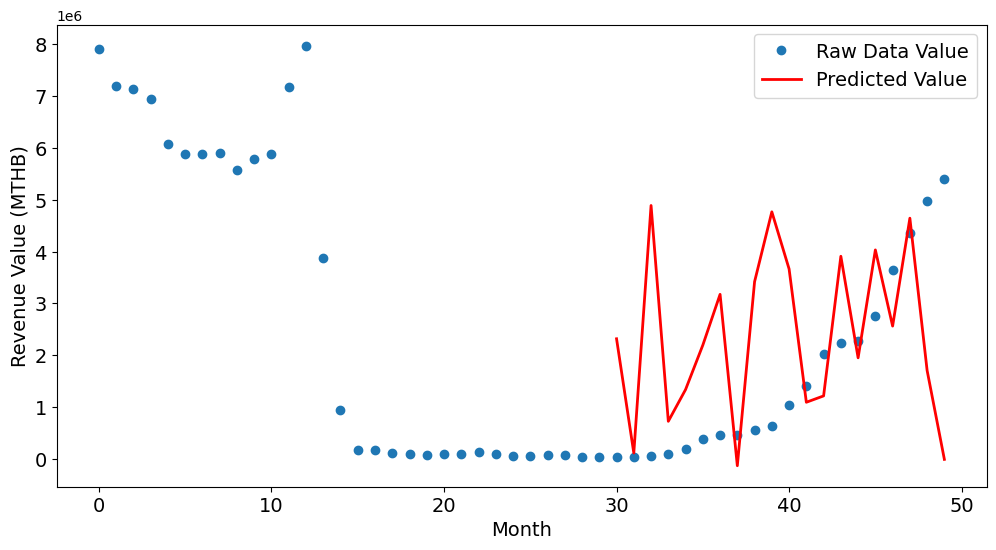

Coefficient: [[-122528.32152629]]
Intercept: [5749591.10100816]
Train set accuracy = 0.37763434518998196
Test set accuracy = -0.4229124806984512
RMSE: 2663310.878336215
MSE: 7093224834664.021
Mean is : 2492191.64
R-squared: -0.4229124806984512
Mean Absolute Error (MAE): 2305380.3117710566
Normalized Mean Absolute Error (NMAE) (หารด้วยค่า range): 0.29021386703537555
NMAE (หารด้วยค่าเฉลี่ย): 0.9250413470494815
2492191.64
NRMSE (หารด้วยค่าเฉลี่ย): 1.0686621508513747


In [6]:
# Linear Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statistics
from sklearn.metrics import r2_score

# Get dataset
df = pd.read_excel('C:/Users/Yuwanut/Desktop/Master@KU/อ.เทพฤทธิ์/Data/no_tourist_foreign.xlsx')
df1 = df.groupby("date")["value"].sum().reset_index()

df1.drop(['date'], axis=1, inplace=True)
#df1.drop(['region_eng'], axis=1, inplace=True)
df1['Time'] = np.arange(len(df1.index))

# Describe data
df1.describe()

# Splitting variables
X = df1['Time'].values.reshape(-1, 1)
y = df1['value'].values.reshape(-1, 1)

# Splitting dataset into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 12)

# Regressor model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Prediction result
y_pred_test = regressor.predict(X_test)     # predicted value of y_test
y_pred_train = regressor.predict(X_train)   # predicted value of y_train

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(df1['Time'], df1['value'], 'o', label = 'Raw Data Value')           # scatter plot showing actual data
plt.plot(df1['Time'].iloc[-len(y_test):], y_pred_test, 'r', linewidth=2, label = 'Predicted Value')   # regression line
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Revenue Value (MTHB)', fontsize = 14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Regressor coefficients and intercept
print(f'Coefficient: {regressor.coef_}')
print(f'Intercept: {regressor.intercept_}')

# Evaluate model's accuracy on train and test set มีค่าใกล้ 1 ยิ่งดี
print("Train set accuracy = " + str(regressor.score(X_train, y_train)))
print("Test set accuracy = " + str(regressor.score(X_test, y_test)))

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {rmse}")

mse = mean_squared_error(y_test, y_pred_test, squared=True)
print(f"MSE: {mse}")

x = statistics.mean(df1['value'])

# Printing the mean
print("Mean is :", x)

r2 = r2_score(y_test, y_pred_test)
print(f"R-squared: {r2}")

# คำนวณ MAE ระหว่างค่าจริง (y_test) กับค่าที่โมเดลทำนาย (y_pred)
mae = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error (MAE):", mae)

# คำนวณค่า NMAE (MAE / range ของ y)
y_range = np.max(y) - np.min(y)  # หาค่าช่วงของ y
nmae = mae / y_range
print("Normalized Mean Absolute Error (NMAE) (หารด้วยค่า range):", nmae)

# NMAE โดยหารด้วยค่าเฉลี่ย
mean_of_y = np.mean(y)
nmae_by_mean = mae / mean_of_y
print("NMAE (หารด้วยค่าเฉลี่ย):", nmae_by_mean)
print(mean_of_y)

nrmse_by_mean = rmse / mean_of_y
print("NRMSE (หารด้วยค่าเฉลี่ย):", nrmse_by_mean)

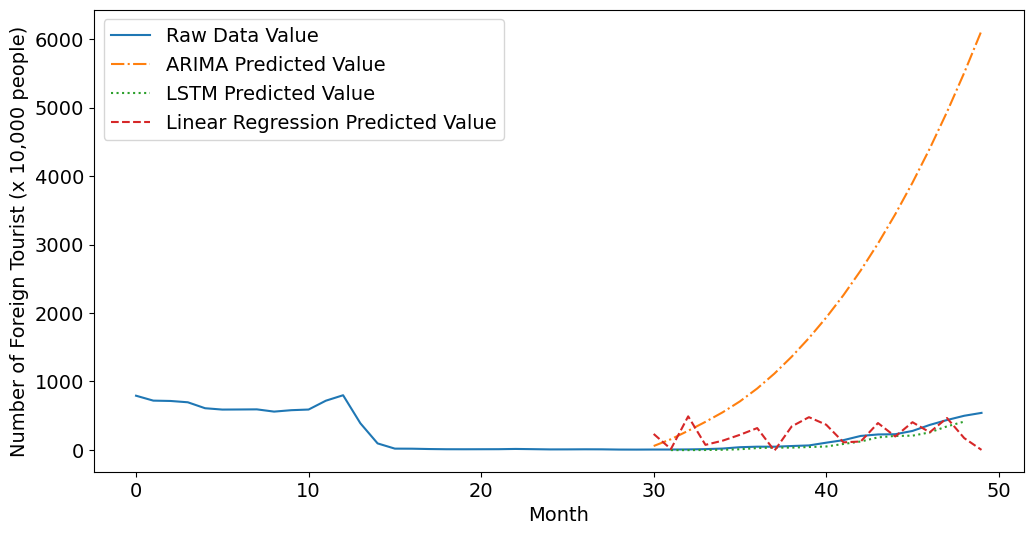

In [7]:
#display actual vs predicted net foreign value
plt.figure(figsize = (12, 6))

plt.plot(scaler.inverse_transform(dataset), label = 'Raw Data Value')
plt.plot(test_data.index, predictions, label = 'ARIMA Predicted Value', linestyle='-.')
plt.plot(testPredictPlot, label = 'LSTM Predicted Value', linestyle=':')
plt.plot(df1['Time'].iloc[-len(y_test):], y_pred_test, label = 'Linear Regression Predicted Value', linestyle='--')   # regression line

plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Foreign Tourist (x 10,000 people)', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

y_ticks = plt.gca().get_yticks()  # รับค่า ticks ในแกน y
plt.gca().set_yticklabels([f'{int(tick / 10000)}' for tick in y_ticks])

ax = plt.gca()  # get current axis
ax.spines['top'].set_visible(True)    # แสดงขอบบน
ax.spines['right'].set_visible(True)  # แสดงขอบขวา
ax.spines['left'].set_visible(True)   # แสดงขอบซ้าย
ax.spines['bottom'].set_visible(True) # แสดงขอบล่าง

plt.show()